# Pre-compute Embeddings from `vggish`


> **NOTE**
>
> You don't have the source data to run this notebook
> and you don't have to!
>
> You have the pre-computed embeddings already.
> 

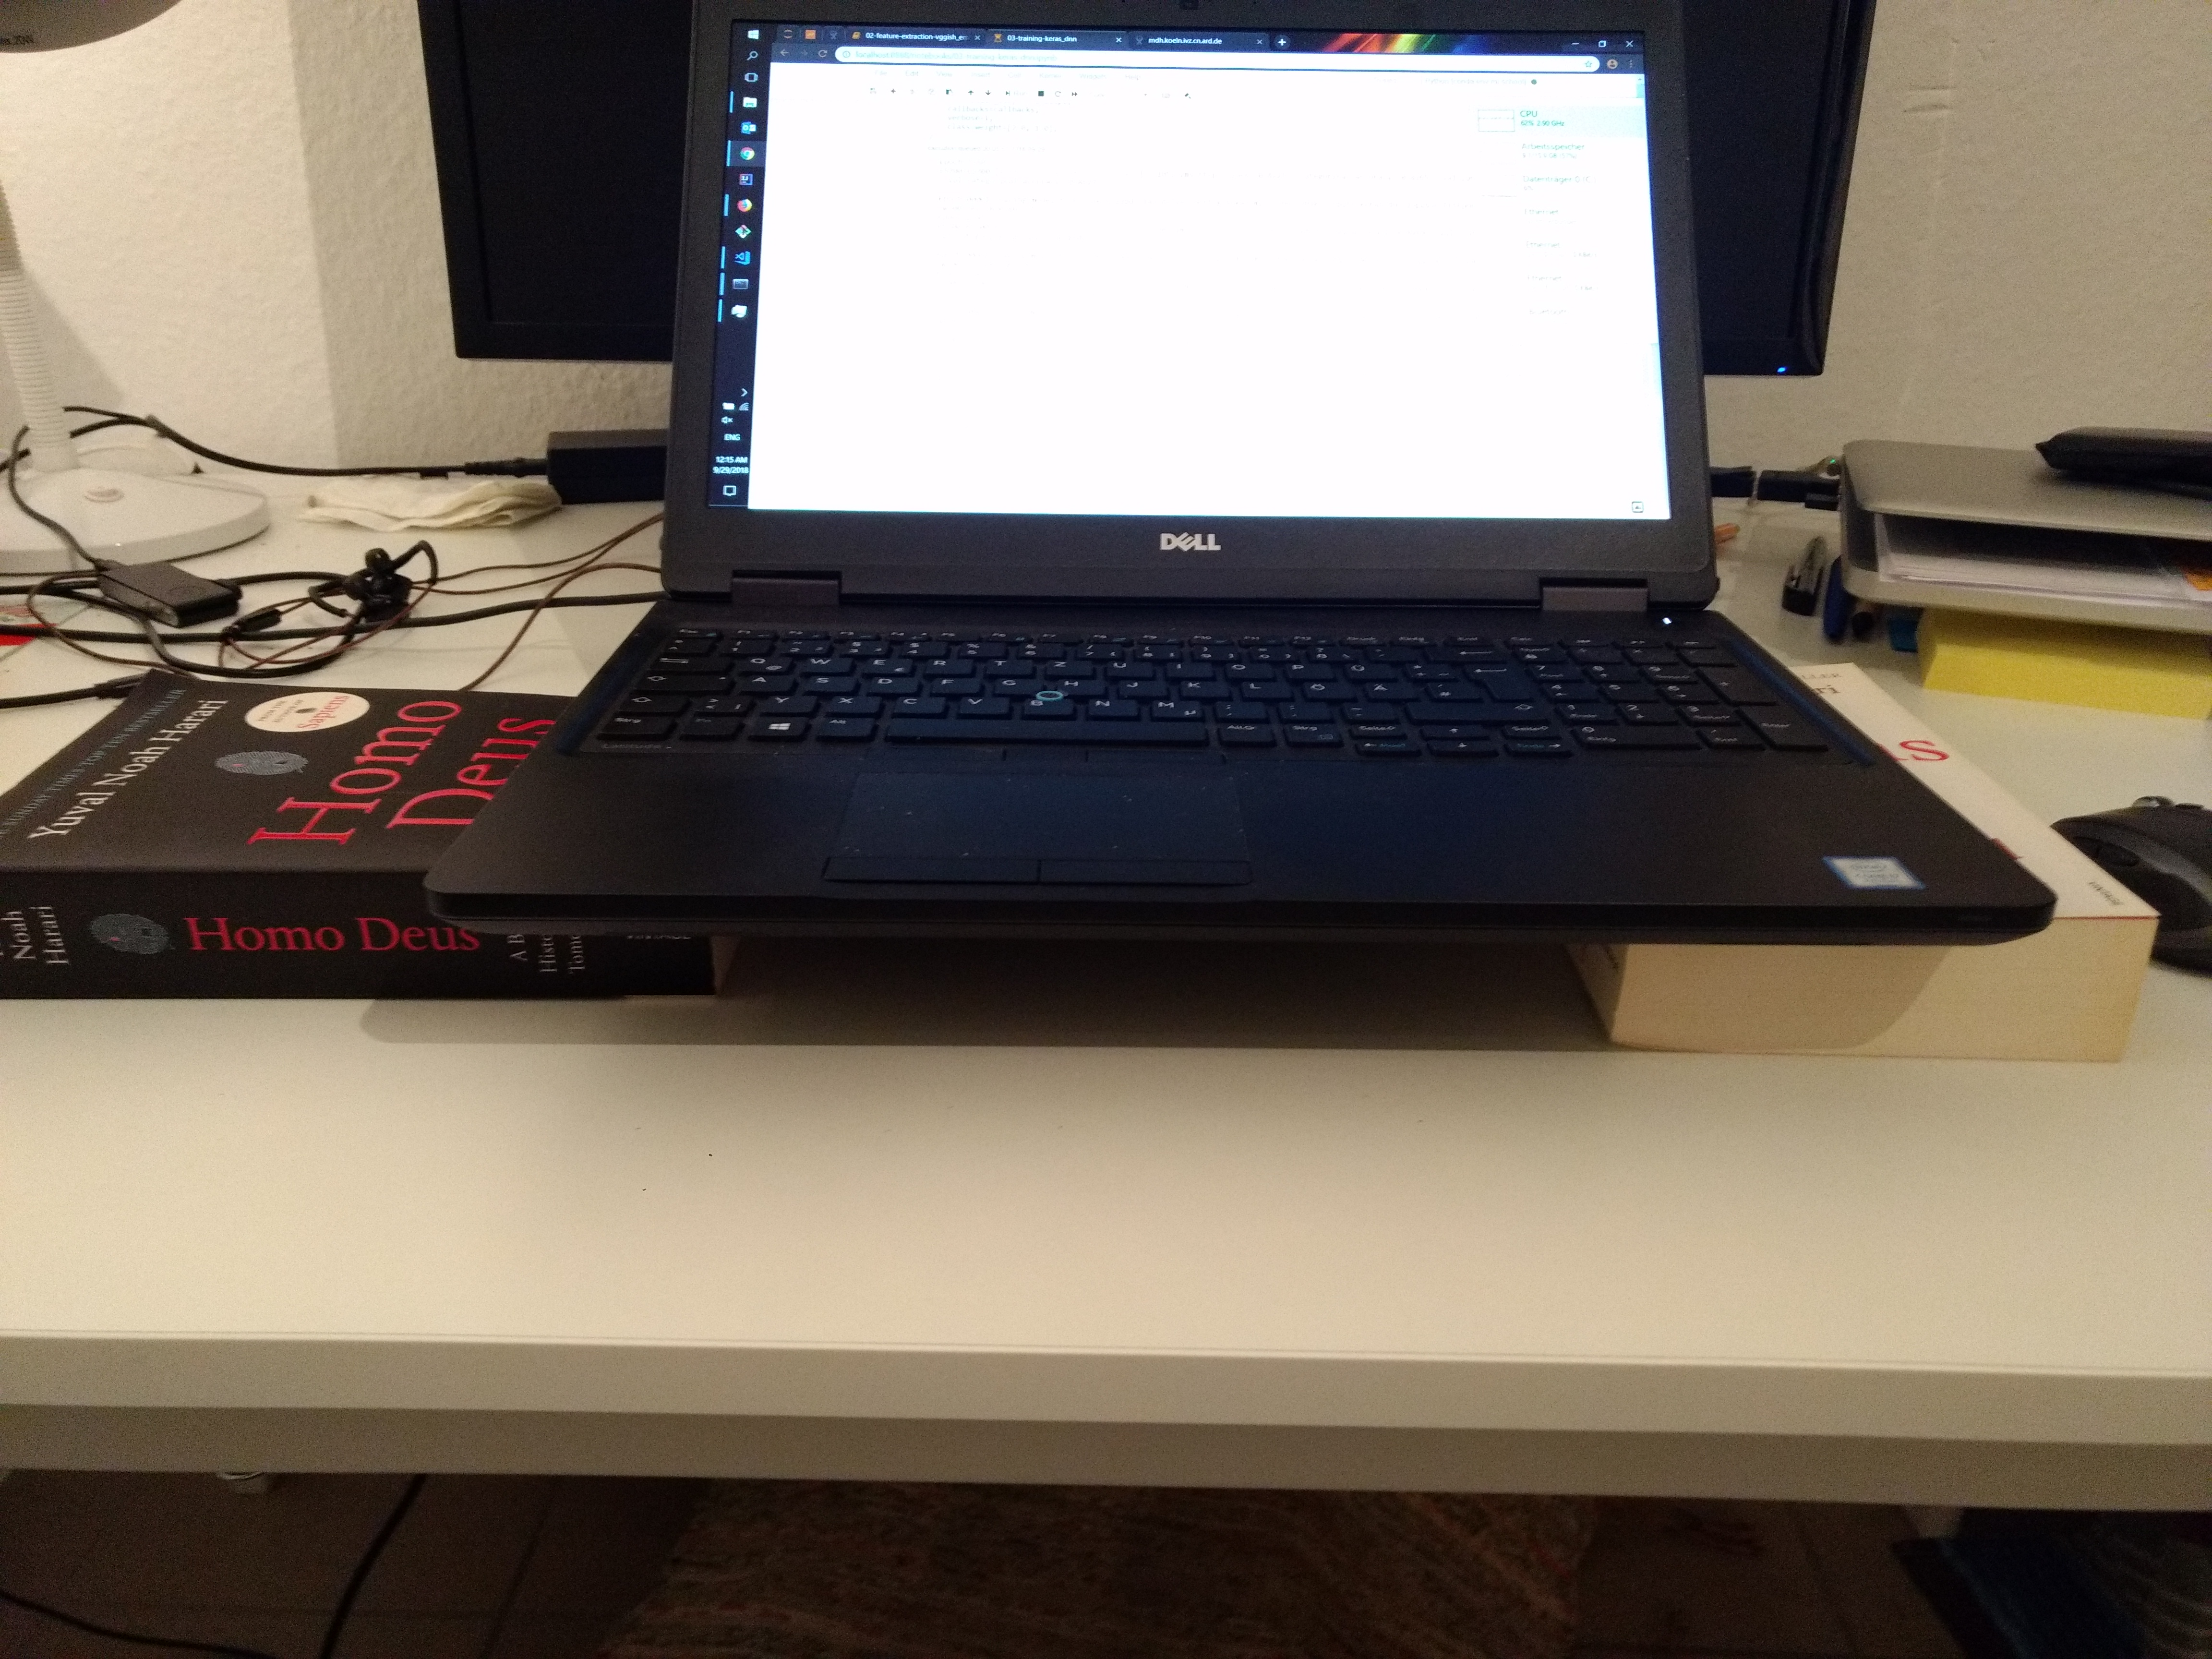


## Requirements

- All data has been split into `train`, `val` and `test` sets.
- All audio data have corresponding labels with the same filename (except extension).
- Running `audioset/vggish_smoke_test.py` is successful.
- Running `pytest tests` from inside `rennet` is successful (ignore warnings for now).

In [1]:
# imports
from pathlib import Path
import tensorflow as tf

import feat_ext as fx
from audioset import vggish_slim
from rennet.datasets.ka3 import ActiveSpeakers

## Prepare Input Filepaths

In [2]:
# Where to look for splits?

dir_splits_root = Path.cwd().joinpath("data/working/ka3/fx/splits_20180927")

if not dir_splits_root.exists():
    raise RuntimeError(f"splits_root does not exist at: {dir_splits_root}")
    
print(f'splits_root:\n{dir_splits_root}')

splits_root:
C:\Users\aabdullah\delve\sonstiges\ka3-ml-school-2018\data\working\ka3\fx\splits_20180927


In [3]:
dir_trn = dir_splits_root.joinpath('trn')
dir_val = dir_splits_root.joinpath('val')
dir_tst = dir_splits_root.joinpath('tst')

for split in [dir_trn, dir_val, dir_tst]:
    if not split.exists():
        raise RuntimeError(f'split directory does not exist: {split}')
        
print('splits:', dir_trn, dir_val, dir_tst, sep='\n')

splits:
C:\Users\aabdullah\delve\sonstiges\ka3-ml-school-2018\data\working\ka3\fx\splits_20180927\trn
C:\Users\aabdullah\delve\sonstiges\ka3-ml-school-2018\data\working\ka3\fx\splits_20180927\val
C:\Users\aabdullah\delve\sonstiges\ka3-ml-school-2018\data\working\ka3\fx\splits_20180927\tst


In [ ]:
def get_ActiveSpeakers_labels(filepath):
    return ActiveSpeakers.from_file(
        filepath, 
        use_tags='ns', 
        tiers=lambda tn: "x@" in tn or tn.startswith("sp"), 
        warn_duplicates=False
    )

pairs_trn = fx.AudioLabelPair.all_in_dir(dir_trn, "**/*.wav", ["**/*.eaf", "**/*.xml"], labels_parser=get_ActiveSpeakers_labels)
pairs_val = fx.AudioLabelPair.all_in_dir(dir_val, "**/*.wav", ["**/*.eaf", "**/*.xml"], labels_parser=get_ActiveSpeakers_labels)
pairs_tst = fx.AudioLabelPair.all_in_dir(dir_tst, "**/*.wav", ["**/*.eaf", "**/*.xml"], labels_parser=get_ActiveSpeakers_labels)

In [6]:
print(f'trn audio-label-pairs: {len(pairs_trn)}\t{sum(p.audio.seconds for p in pairs_trn):9.2f} sec')
print(f'val audio-label-pairs: {len(pairs_val)}\t{sum(p.audio.seconds for p in pairs_val):9.2f} sec')
print(f'tst audio-label-pairs: {len(pairs_tst)}\t{sum(p.audio.seconds for p in pairs_tst):9.2f} sec')

trn audio-label-pairs: 160	 77162.04 sec
val audio-label-pairs: 8	  4262.33 sec
tst audio-label-pairs: 62	 33460.37 sec


In [7]:
import numpy as np

pairs_splits = [
        ('val', pairs_val), 
        ('tst', pairs_tst), 
        ('trn', pairs_trn)
]

print("Percentage of [silence, speech] per split:\n")
for name, pairs in pairs_splits:
    labels = np.zeros(2)
    for pair in pairs:
        labels += pair._get_label_examples().sum(axis=0)
        
    print(name, 100 * labels / labels.sum())

Percentage of [silence, speech] per split:

val [31.28018978 68.71981022]
tst [35.41842402 64.58157598]
trn [35.81076051 64.18923949]


## Prepare Output Filepaths

In [ ]:
# Where to output

dir_pickles_root = dir_splits_root.joinpath("pickles2")

dir_this_pickles = dir_pickles_root.joinpath("20180927-vggish_embedding")
dir_this_pickles.mkdir(exist_ok=True, parents=True)

print(f'pickles for each split will be saved at:\n{dir_this_pickles}')

## Write Pickles (`tfrecord`) for each split

### VGGish model files

In [8]:
dir_vggish = Path.cwd().joinpath('data/models/vggish')
fp_vggish_model = dir_vggish.joinpath('vggish_model.ckpt')
fp_vggish_pca_params = dir_vggish.joinpath('vggish_pca_params.npz')

for fp in [fp_vggish_model, fp_vggish_pca_params]:
    if not fp.exists():
        raise RuntimeError("model file {fp} not found.")
        
print(f'vggish_model:\n{fp_vggish_model}\n')
print(f'vggish_pca_params:\n{fp_vggish_pca_params}')

vggish_model:
C:\Users\aabdullah\delve\sonstiges\ka3-ml-school-2018\data\models\vggish\vggish_model.ckpt

vggish_pca_params:
C:\Users\aabdullah\delve\sonstiges\ka3-ml-school-2018\data\models\vggish\vggish_pca_params.npz


In [21]:
def parse(proto):
    context_features = {k: v.Feature_type for k, v in fx.AudioLabelPair.context_features.items()}
    
    sequence_features = {
        "embedding": tf.FixedLenSequenceFeature([3], dtype=tf.float32),
        "speechact": tf.FixedLenSequenceFeature([2], dtype=tf.float32),
    }
    
    _, feat_labels = tf.parse_single_sequence_example(
        proto,
        context_features=context_features,
        sequence_features=sequence_features,
    )
    e = feat_labels["embedding"]
    
    return {"embedding": e}, feat_labels['speechact']

def input_fn():
    dataset = tf.data.TFRecordDataset("t.tfrecord")
    dataset = dataset.map(parse)
    dataset = dataset.repeat()
    dataset = dataset.batch(32)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [ ]:
post_processor = fx.get_pre_processor(fp_vggish_pca_params)

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
with tf.Graph().as_default(), tf.Session() as sess:
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, str(fp_vggish_model.absolute()))
    
    pairs_splits = [
            ('val', pairs_val), 
#             ('tst', pairs_tst), 
            ('trn', pairs_trn)
    ]
    seconds = [sum(p.audio.nsamples for p in ps) for (_, ps) in pairs_splits]
    main_pbar = tqdm(total=sum(seconds))
    for ((name, pairs), sec) in zip(pairs_splits, seconds):
        split_pbar = tqdm(total=sec)
        main_pbar.set_description(name)
        with tf.python_io.TFRecordWriter(str(dir_this_pickles.joinpath(f'{name}.tfrecord'))) as writer:
            for (i, pair) in enumerate(pairs):
                try:
                    ex = pair.to_vggish_SequenceExample(sess, post_processor)
                    writer.write(ex.SerializeToString())
                except (KeyboardInterrupt, SystemExit):
                    raise
                except:
                    print(pair.audio)
                    print(pair._get_audio_examples().shape)
                    print(pair._get_label_examples().shape)
                
                main_pbar.update(pair.audio.nsamples)
                split_pbar.update(pair.audio.nsamples)
            split_pbar.close()
    main_pbar.close()
    